
Average number of tokens per item: 404
Standard deviation of tokens per item:424
Median tokens per item:290
Chosen token window: 1254 - Covers 96.19289340101524% of the dataset
Average number of tokens per title:7
Standard deviation of tokens by title:3
Media of token by title: 8
Chosen token window: 13 - Covers 97.91878172588832% of the dataset


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.5397631133671743

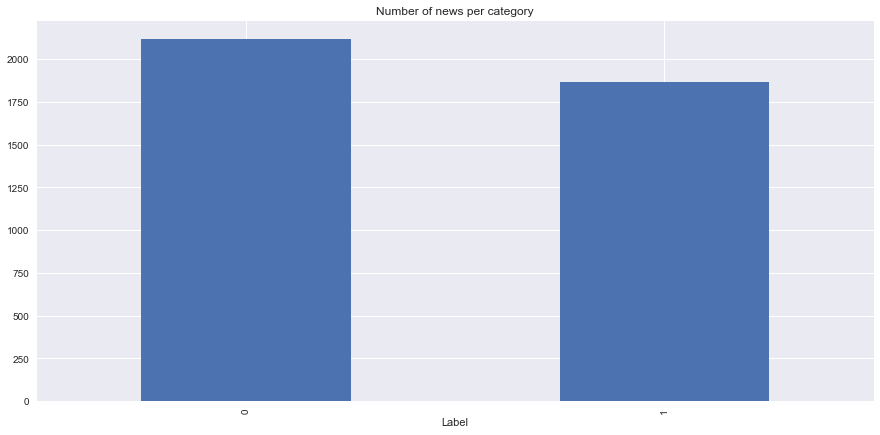

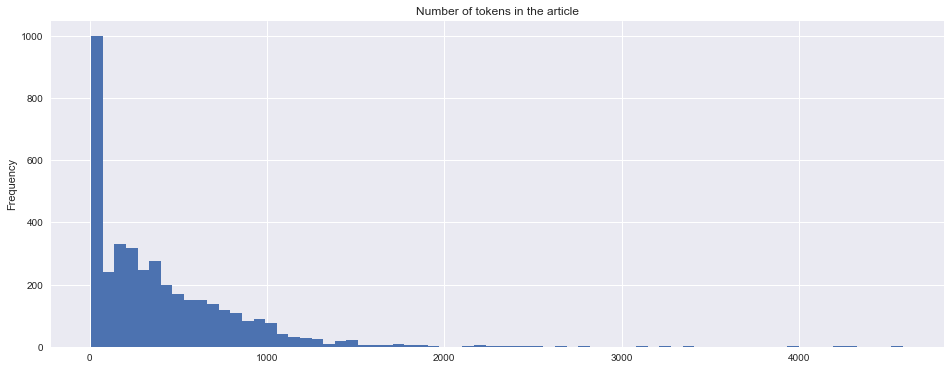

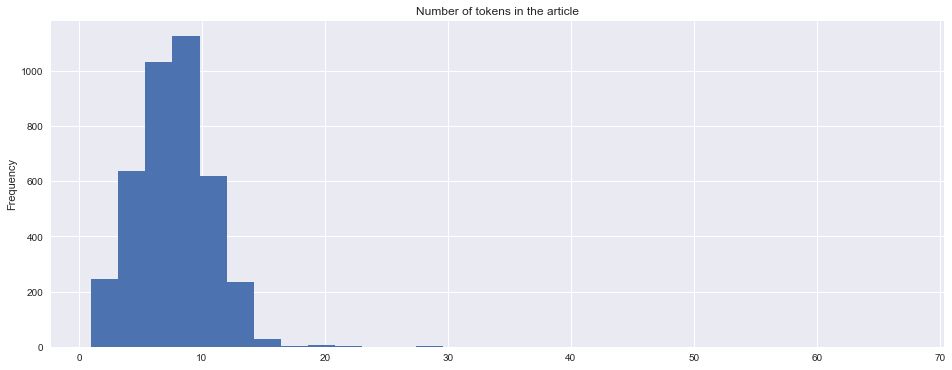

In [11]:
import pandas as pd 
import numpy as np
#Progress bars
from tqdm import tqdm
tqdm.pandas()
#Paralelize pandas apply on multiple cores
import swifter
from matplotlib import pyplot as plt
from matplotlib import style

#Nicer style
style.use('seaborn') 

import re #regexp
from nltk.tokenize import RegexpTokenizer

#word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array


#PATH_DATASET = "../data.csv"

#Padding number for title and content
MAX_LEN_TITLE = 13
MAX_LEN_CONTENT = 1598

#Convert labels
LBL_TRUE = [0,0,0,1]
LBL_FAKE = [0,0,1,0]
df = pd.read_csv("data.csv", sep=',', header = 'infer')

df.head()
df.isna()

df = df.dropna()
plt.figure(figsize=(15,7))
df.groupby('Label').count()['Headline'].plot.bar(title="Number of news per category")



#Clean content
df['Body'] = df.swifter.apply(lambda row: clean_text(row['Body']), axis=1)
#Clean title
df['Headline'] = df.swifter.apply(lambda row: clean_text(row['Headline']), axis=1)

df.isna().sum()
df = df.dropna()
df.isna().sum() 

#from gensim.models.keyedvectors import KeyedVector
model = KeyedVectors.load_word2vec_format("E:\Fall 2020\Python\GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000,encoding="ISO-8859-1")

df['Headline'] = df.swifter.apply(lambda r: 
                        [model.vocab[x].index for x in r['Headline'] if x in model.vocab], axis=1)
df['Body'] = df.swifter.apply(lambda r: 
                        [model.vocab[x].index for x in r['Body'] if x in model.vocab], axis=1)


#Drop news with short or no title
df = df[df['Headline'].map(len) >= 1]
#Reset index
df = df.reset_index().drop("index", axis=1)

df.isna().sum()
df = df.dropna()
df.isna().sum()

tokens_numbers = df.swifter.apply(lambda row: len(row['Body']), axis = 1)
#tokens_numbers
fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)


print("Average number of tokens per item: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per item:{}".format(int(np.std(tokens_numbers))))
print("Median tokens per item:{}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens*100))
tokens_numbers = df.apply(lambda row: len(row['Headline']), axis = 1)
fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Average number of tokens per title:{}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens by title:{}".format(int(np.std(tokens_numbers))))
print("Media of token by title: {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens*100))

df['Headline'] = df.apply(lambda r: pad_array(r['Headline'], MAX_LEN_TITLE) , axis=1)
df['Body'] = df.apply(lambda r: pad_array(r['Body'], MAX_LEN_CONTENT) , axis=1)

x_headline = df.iloc[:,1:2]
x_body = df.iloc[:,2:3]
y = df.iloc[:,-1:]

x_headline = np.array(x_headline.values.tolist())
x_body = np.array(x_body.values.tolist())
y = np.array(y.values.tolist())

# 3D array into 2D array
nsamples, nx, ny = x_headline.shape
x_d2_headline = x_headline.reshape((nsamples,nx*ny))
nsamples, nx, ny = x_body.shape
x_d2_body = x_body.reshape((nsamples,nx*ny))
x = np.hstack((x_d2_headline,x_d2_body))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 42)

log_reg = LogisticRegression(n_jobs=1, C = 1e5)
lr = log_reg.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

In [13]:
df.head(10)

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,"[2675, 1143, 2205, 48926, 6117, 13034, 0, 0, 0...","[15680, 8429, 28683, 14257, 312, 281, 565, 611...",1
1,https://www.reuters.com/article/us-filmfestiva...,"[556, 2168, 3912, 5042, 2360, 508, 115, 948, 0...","[4949, 20876, 17535, 3912, 46, 3610, 556, 3230...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,"[13034, 12828, 316, 48926, 553, 16854, 23325, ...","[7, 14446, 1506, 69, 208, 995, 64, 116, 61, 60...",1
3,https://www.reuters.com/article/us-mexico-oil-...,"[2905, 1469, 1930, 8, 44732, 2, 3538, 19568, 4...","[29922, 2905, 6585, 4840, 301, 11, 1080, 1428,...",1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,"[2678, 3466, 8, 11440, 5739, 0, 0, 0, 0, 0, 0,...","[4868, 3076, 2678, 31, 10, 3246, 14, 11, 11440...",1
5,http://beforeitsnews.com/sports/2017/09/jetnat...,"[1547, 3388, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1547, 3388, 2342, 153, 28, 550, 4, 28151, 702...",0
6,https://www.nytimes.com/2017/10/10/us/politics...,"[2860, 6601, 4613, 11327, 13034, 51, 43631, 0,...","[70, 2860, 1885, 363, 18, 25037, 3613, 32062, ...",1
7,https://www.reuters.com/article/us-india-cenba...,"[563, 3356, 714, 376, 396, 33, 13, 12, 370, 18...","[7, 7861, 669, 563, 4020, 13490, 12023, 303, 5...",1
8,https://www.reuters.com/article/us-climatechan...,"[5426, 714, 962, 1650, 5, 13459, 2804, 4613, 4...","[1397, 28728, 11999, 11, 6038, 6330, 10600, 30...",1
9,https://www.reuters.com/article/us-air-berlin-...,"[11737, 5, 969, 3042, 5418, 4594, 49174, 12, 6...","[11409, 33714, 741, 3042, 5418, 962, 4, 468, 1...",1


In [5]:
y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])